In [1]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import util
from pathlib import Path
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import davies_bouldin_score
from class_manipulates_path import ManipulatePath
from class_preprocessing_refactor import Preprocessing
from class_format_data import FormatData
util.init()

'Módulo util importado com sucesso.'

In [2]:
def plot_variable(df, column_name):
    """
    Plota um gráfico de dispersão para uma variável de um DataFrame.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - column_name: Nome da coluna que você deseja plotar.
        - intervalos: Lista de intervalos para plotar linhas verticais.
    """
    plt.figure(figsize=(20, 10))
    plt.scatter(df.index.values, df[column_name].values, color='darkcyan', alpha=0.5)
    plt.xlabel('Índice')
    plt.ylabel(column_name)
    plt.title(f'Gráfico de dispersão para a variável "{column_name}"')

    plt.show()

In [3]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [4]:
def plot_two_variables(df, var1, var2, binary_column=None):
    """
    Plota um gráfico de dispersão para duas variáveis de um DataFrame, colorindo os pontos conforme uma coluna binária, se fornecida.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - var1: Nome da primeira variável (eixo x).
        - var2: Nome da segunda variável (eixo y).
        - binary_column: Nome da coluna binária usada para colorir os pontos (opcional).
    """
    plt.figure(figsize=(10, 6))

    if binary_column is not None:
        # Obtendo os valores únicos da coluna binária
        classes = df[binary_column].unique()

        # Criando um mapeamento de classe para cor
        colors = {cls: plt.cm.tab10(i) for i, cls in enumerate(classes)}

        # Colorindo os pontos de acordo com as classes
        for cls in classes:
            df_cls = df[df[binary_column] == cls]
            plt.scatter(df_cls[var1], df_cls[var2], color=colors[cls], label=cls, alpha=0.5)
        
        plt.legend(title=binary_column)
    else:
        plt.scatter(df[var1], df[var2], alpha=0.5)

    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'Gráfico de Dispersão: {var1} vs {var2}')
    plt.grid(True)
    plt.show()

In [5]:
def plot_variavel_e_histograma(dataframe, nome_coluna):
    # Verifica se a coluna existe no DataFrame
    if nome_coluna not in dataframe.columns:
        print("A coluna especificada não existe no DataFrame.")
        return
    
    # Plota a variável ao longo do tempo
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    dataframe[nome_coluna].plot()
    plt.title("Variação ao longo do tempo")
    plt.xlabel("Índice")
    plt.ylabel(nome_coluna)
    
    # Plota o histograma da variável
    plt.subplot(1, 2, 2)
    dataframe[nome_coluna].hist()
    plt.title("Histograma")
    plt.xlabel(nome_coluna)
    plt.ylabel("Frequência")
    
    plt.tight_layout()
    plt.show()

In [6]:
def kmeans_two_variables(df, var1, var2, n_clusters=3):
    """
    Aplica o algoritmo K-means para agrupar duas variáveis de um DataFrame.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - var1: Nome da primeira variável.
        - var2: Nome da segunda variável.
        - n_clusters: Número de clusters (padrão é 3).
    """
    # Seleciona as duas variáveis
    X = df[[var1, var2]]

    # Aplica o algoritmo K-means
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)

    # Obtém as coordenadas dos centroides
    centroids = kmeans.cluster_centers_

    # Plota os pontos e os centroides
    plt.figure(figsize=(10, 6))
    plt.scatter(X[var1], X[var2], c=kmeans.labels_, cmap='viridis', alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, color='red')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'K-means: {var1} vs {var2}')
    plt.grid(True)
    plt.show()

In [7]:
def extract_well_number(path):
    match = re.search(r'WELL-(\d+)_', path)
    if match:
        return match.group(1)
    else:
        return None

In [8]:
manipulate_path = ManipulatePath()

preprocessing = Preprocessing()

format_data = FormatData()

path_raw_data = manipulate_path.get_path_raw_data()

abnormal_classes_codes = [1, 2, 5, 6, 7, 8]

In [9]:
# Gets all real instances but maintains only those with any type of undesirable event
real_instances = pd.DataFrame(class_and_file_generator(path_raw_data, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
real_instances = real_instances.loc[real_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)

In [10]:
# filtra somente arquivos da falha 1
real_instances = real_instances[real_instances["class_code"] == 1].copy()

In [11]:
list_group = []
for path in real_instances['instance_path'].values:
    path = str(path)
    list_group.append(int(extract_well_number(path)))

real_instances['numero_poco'] = pd.Series(list_group)

In [12]:
poco = 6
file_paths = real_instances[real_instances["numero_poco"] == poco]["instance_path"].values

In [13]:
df_data = pd.read_csv(str(file_paths[0]))
df_data = FormatData.set_index_dataframe(df_data=df_data,
                                         column_name="timestamp")
df_output = df_data.copy()

In [14]:
df_output

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
timestamp,,,,,,,,,
2017-07-31 18:09:30,44858050.0,18373560.0,118.4004,2538033.0,78.87206,1277608.0,NaN,0.0,0.0
2017-07-31 18:09:31,44858050.0,18373560.0,118.4001,2538033.0,78.87207,1277610.0,NaN,0.0,0.0
2017-07-31 18:09:32,44858050.0,18373560.0,118.3998,2538032.0,78.87208,1277611.0,NaN,0.0,0.0
2017-07-31 18:09:33,44858050.0,18373560.0,118.3995,2538031.0,78.87208,1277612.0,NaN,0.0,0.0
2017-07-31 18:09:34,44858050.0,18373560.0,118.3991,2538030.0,78.87209,1277614.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2017-08-01 20:44:56,44858050.0,17922060.0,119.3238,3522329.0,77.92796,1308528.0,NaN,0.0,1.0
2017-08-01 20:44:57,44858050.0,17922220.0,119.3240,3534952.0,77.91788,1308529.0,NaN,0.0,1.0
2017-08-01 20:44:58,44858050.0,17922380.0,119.3241,3547575.0,77.90780,1308530.0,NaN,0.0,1.0


In [15]:
df_output = df_output[~df_output.index.duplicated()]
df_output.shape

(95731, 9)

In [16]:
for column_name in df_output.columns:
    percent = Preprocessing.check_null_dataframe(df_data=df_output, column_name=column_name)
    print(f"{column_name} null data is {percent}")

P-PDG null data is 0.0
P-TPT null data is 0.0
T-TPT null data is 0.0
P-MON-CKP null data is 0.0
T-JUS-CKP null data is 0.0
P-JUS-CKGL null data is 0.0
T-JUS-CKGL null data is 100.0
QGL null data is 0.0
class null data is 0.3300916108679529


In [17]:
df_preprocessing = df_output.drop(columns=["T-JUS-CKGL"])
df_preprocessing

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,class
timestamp,,,,,,,,
2017-07-31 18:09:30,44858050.0,18373560.0,118.4004,2538033.0,78.87206,1277608.0,0.0,0.0
2017-07-31 18:09:31,44858050.0,18373560.0,118.4001,2538033.0,78.87207,1277610.0,0.0,0.0
2017-07-31 18:09:32,44858050.0,18373560.0,118.3998,2538032.0,78.87208,1277611.0,0.0,0.0
2017-07-31 18:09:33,44858050.0,18373560.0,118.3995,2538031.0,78.87208,1277612.0,0.0,0.0
2017-07-31 18:09:34,44858050.0,18373560.0,118.3991,2538030.0,78.87209,1277614.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2017-08-01 20:44:56,44858050.0,17922060.0,119.3238,3522329.0,77.92796,1308528.0,0.0,1.0
2017-08-01 20:44:57,44858050.0,17922220.0,119.3240,3534952.0,77.91788,1308529.0,0.0,1.0
2017-08-01 20:44:58,44858050.0,17922380.0,119.3241,3547575.0,77.90780,1308530.0,0.0,1.0


In [18]:
for column_name in df_preprocessing.columns:
    percent = Preprocessing.check_column_low_variance(df_data=df_preprocessing, column_name=column_name)
    print(f"{column_name} low variance is {percent}")

P-PDG low variance is 1
P-TPT low variance is 0
T-TPT low variance is 0
P-MON-CKP low variance is 0
T-JUS-CKP low variance is 0
P-JUS-CKGL low variance is 0
QGL low variance is 1
class low variance is 0


In [19]:
df_preprocessing = df_preprocessing.drop(columns=["P-PDG", "P-JUS-CKGL", "QGL"])
df_preprocessing

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class
timestamp,,,,,
2017-07-31 18:09:30,18373560.0,118.4004,2538033.0,78.87206,0.0
2017-07-31 18:09:31,18373560.0,118.4001,2538033.0,78.87207,0.0
2017-07-31 18:09:32,18373560.0,118.3998,2538032.0,78.87208,0.0
2017-07-31 18:09:33,18373560.0,118.3995,2538031.0,78.87208,0.0
2017-07-31 18:09:34,18373560.0,118.3991,2538030.0,78.87209,0.0
...,...,...,...,...,...
2017-08-01 20:44:56,17922060.0,119.3238,3522329.0,77.92796,1.0
2017-08-01 20:44:57,17922220.0,119.3240,3534952.0,77.91788,1.0
2017-08-01 20:44:58,17922380.0,119.3241,3547575.0,77.90780,1.0


In [20]:
df_preprocessing = df_preprocessing.dropna()

In [21]:
df_preprocessing

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class
timestamp,,,,,
2017-07-31 18:09:30,18373560.0,118.4004,2538033.0,78.87206,0.0
2017-07-31 18:09:31,18373560.0,118.4001,2538033.0,78.87207,0.0
2017-07-31 18:09:32,18373560.0,118.3998,2538032.0,78.87208,0.0
2017-07-31 18:09:33,18373560.0,118.3995,2538031.0,78.87208,0.0
2017-07-31 18:09:34,18373560.0,118.3991,2538030.0,78.87209,0.0
...,...,...,...,...,...
2017-08-01 20:44:56,17922060.0,119.3238,3522329.0,77.92796,1.0
2017-08-01 20:44:57,17922220.0,119.3240,3534952.0,77.91788,1.0
2017-08-01 20:44:58,17922380.0,119.3241,3547575.0,77.90780,1.0


In [22]:
columns_poly = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']

In [23]:
def polynomial_features(df, columns):
    df_data = df.copy()
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly_features = poly.fit_transform(df_data[columns])
    feature_names = poly.get_feature_names_out(input_features=columns)
    df_poly = pd.DataFrame(poly_features, columns=feature_names, index=df_data.index)
    df_poly = df_poly.drop(columns=columns)
    df = pd.concat([df, df_poly],axis=1)
    return df

In [24]:
df_preprocessing = polynomial_features(df_preprocessing.copy(), columns_poly)

In [25]:
df_preprocessing

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class,P-TPT T-TPT,P-TPT P-MON-CKP,P-TPT T-JUS-CKP,T-TPT P-MON-CKP,T-TPT T-JUS-CKP,P-MON-CKP T-JUS-CKP
timestamp,,,,,,,,,,,
2017-07-31 18:09:30,18373560.0,118.4004,2538033.0,78.87206,0.0,2.175437e+09,4.663270e+13,1.449161e+09,3.005041e+08,9338.483453,2.001799e+08
2017-07-31 18:09:31,18373560.0,118.4001,2538033.0,78.87207,0.0,2.175431e+09,4.663270e+13,1.449161e+09,3.005034e+08,9338.460975,2.001799e+08
2017-07-31 18:09:32,18373560.0,118.3998,2538032.0,78.87208,0.0,2.175426e+09,4.663268e+13,1.449161e+09,3.005025e+08,9338.438498,2.001799e+08
2017-07-31 18:09:33,18373560.0,118.3995,2538031.0,78.87208,0.0,2.175420e+09,4.663266e+13,1.449161e+09,3.005016e+08,9338.414836,2.001798e+08
2017-07-31 18:09:34,18373560.0,118.3991,2538030.0,78.87209,0.0,2.175413e+09,4.663265e+13,1.449161e+09,3.005005e+08,9338.384471,2.001797e+08
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-01 20:44:56,17922060.0,119.3238,3522329.0,77.92796,1.0,2.138528e+09,6.312739e+13,1.396630e+09,4.202977e+08,9298.660313,2.744879e+08
2017-08-01 20:44:57,17922220.0,119.3240,3534952.0,77.91788,1.0,2.138551e+09,6.335419e+13,1.396461e+09,4.218046e+08,9297.473113,2.754360e+08
2017-08-01 20:44:58,17922380.0,119.3241,3547575.0,77.90780,1.0,2.138572e+09,6.358099e+13,1.396293e+09,4.233112e+08,9296.278118,2.763838e+08


In [26]:
def calcular_estatisticas_janela_otimizado(df, column_name, window_size):
    # Calcular os índices de início e fim da janela para cada linha
    indices_inicio_janela = np.arange(len(df) - window_size + 1)
    indices_fim_janela = indices_inicio_janela + window_size
    
    # Calcular as estatísticas para cada janela de uma vez
    min_values = df[column_name].rolling(window=window_size, min_periods=1).min().iloc[indices_fim_janela - 1].values
    max_values = df[column_name].rolling(window=window_size, min_periods=1).max().iloc[indices_fim_janela - 1].values
    mean_values = df[column_name].rolling(window=window_size, min_periods=1).mean().iloc[indices_fim_janela - 1].values
    
    # Criar um novo DataFrame com as estatísticas calculadas
    df_resultado = df.copy()
    df_resultado[f'{column_name}_min'] = np.nan
    df_resultado[f'{column_name}_max'] = np.nan
    df_resultado[f'{column_name}_mean'] = np.nan
    
    df_resultado.iloc[window_size - 1:, df_resultado.columns.get_loc(f'{column_name}_min')] = min_values
    df_resultado.iloc[window_size - 1:, df_resultado.columns.get_loc(f'{column_name}_max')] = max_values
    df_resultado.iloc[window_size - 1:, df_resultado.columns.get_loc(f'{column_name}_mean')] = mean_values
    
    return df_resultado

In [27]:
df_preprocessing

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,class,P-TPT T-TPT,P-TPT P-MON-CKP,P-TPT T-JUS-CKP,T-TPT P-MON-CKP,T-TPT T-JUS-CKP,P-MON-CKP T-JUS-CKP
timestamp,,,,,,,,,,,
2017-07-31 18:09:30,18373560.0,118.4004,2538033.0,78.87206,0.0,2.175437e+09,4.663270e+13,1.449161e+09,3.005041e+08,9338.483453,2.001799e+08
2017-07-31 18:09:31,18373560.0,118.4001,2538033.0,78.87207,0.0,2.175431e+09,4.663270e+13,1.449161e+09,3.005034e+08,9338.460975,2.001799e+08
2017-07-31 18:09:32,18373560.0,118.3998,2538032.0,78.87208,0.0,2.175426e+09,4.663268e+13,1.449161e+09,3.005025e+08,9338.438498,2.001799e+08
2017-07-31 18:09:33,18373560.0,118.3995,2538031.0,78.87208,0.0,2.175420e+09,4.663266e+13,1.449161e+09,3.005016e+08,9338.414836,2.001798e+08
2017-07-31 18:09:34,18373560.0,118.3991,2538030.0,78.87209,0.0,2.175413e+09,4.663265e+13,1.449161e+09,3.005005e+08,9338.384471,2.001797e+08
...,...,...,...,...,...,...,...,...,...,...,...
2017-08-01 20:44:56,17922060.0,119.3238,3522329.0,77.92796,1.0,2.138528e+09,6.312739e+13,1.396630e+09,4.202977e+08,9298.660313,2.744879e+08
2017-08-01 20:44:57,17922220.0,119.3240,3534952.0,77.91788,1.0,2.138551e+09,6.335419e+13,1.396461e+09,4.218046e+08,9297.473113,2.754360e+08
2017-08-01 20:44:58,17922380.0,119.3241,3547575.0,77.90780,1.0,2.138572e+09,6.358099e+13,1.396293e+09,4.233112e+08,9296.278118,2.763838e+08


In [28]:
df_preprocessing.columns

Index(['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class', 'P-TPT T-TPT',
       'P-TPT P-MON-CKP', 'P-TPT T-JUS-CKP', 'T-TPT P-MON-CKP',
       'T-TPT T-JUS-CKP', 'P-MON-CKP T-JUS-CKP'],
      dtype='object')

In [29]:
# df_preprocessing = calcular_estatisticas_janela_otimizado(df_preprocessing.copy(), "T-TPT", 180)
# df_preprocessing = calcular_estatisticas_janela_otimizado(df_preprocessing.copy(), 'P-TPT', 180)
# df_preprocessing = calcular_estatisticas_janela_otimizado(df_preprocessing.copy(), 'T-JUS-CKP', 180)

In [30]:
def atrasar_variavel(df, column_name, window_size):
    df_resultado = df.copy()
    
    # Renomear a coluna alvo
    df_resultado.rename(columns={column_name: f'{column_name} (t)'}, inplace=True)
    
    # Atrasar a variável em uma janela de tamanho window_size
    for i in range(1, window_size + 1):
        df_resultado[f'{column_name} (t-{i})'] = df[column_name].shift(i)
    
    return df_resultado


In [31]:
df_preprocessing = atrasar_variavel(df_preprocessing.copy(), "T-TPT", 180)
#df_preprocessing = atrasar_variavel(df_preprocessing.copy(), "P-TPT", 180)
#df_preprocessing = atrasar_variavel(df_preprocessing.copy(), "T-JUS-CKP", 180)

C:\Users\marce\AppData\Local\Temp\ipykernel_7244\3623889669.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resultado[f'{column_name} (t-{i})'] = df[column_name].shift(i)
C:\Users\marce\AppData\Local\Temp\ipykernel_7244\3623889669.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resultado[f'{column_name} (t-{i})'] = df[column_name].shift(i)
C:\Users\marce\AppData\Local\Temp\ipykernel_7244\3623889669.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

In [32]:
df_preprocessing

,P-TPT,T-TPT (t),P-MON-CKP,T-JUS-CKP,class,P-TPT T-TPT,P-TPT P-MON-CKP,P-TPT T-JUS-CKP,T-TPT P-MON-CKP,T-TPT T-JUS-CKP,...,T-TPT (t-171),T-TPT (t-172),T-TPT (t-173),T-TPT (t-174),T-TPT (t-175),T-TPT (t-176),T-TPT (t-177),T-TPT (t-178),T-TPT (t-179),T-TPT (t-180)
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-07-31 18:09:30,18373560.0,118.4004,2538033.0,78.87206,0.0,2.175437e+09,4.663270e+13,1.449161e+09,3.005041e+08,9338.483453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-31 18:09:31,18373560.0,118.4001,2538033.0,78.87207,0.0,2.175431e+09,4.663270e+13,1.449161e+09,3.005034e+08,9338.460975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-31 18:09:32,18373560.0,118.3998,2538032.0,78.87208,0.0,2.175426e+09,4.663268e+13,1.449161e+09,3.005025e+08,9338.438498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-31 18:09:33,18373560.0,118.3995,2538031.0,78.87208,0.0,2.175420e+09,4.663266e+13,1.449161e+09,3.005016e+08,9338.414836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-31 18:09:34,18373560.0,118.3991,2538030.0,78.87209,0.0,2.175413e+09,4.663265e+13,1.449161e+09,3.005005e+08,9338.384471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-01 20:44:56,17922060.0,119.3238,3522329.0,77.92796,1.0,2.138528e+09,6.312739e+13,1.396630e+09,4.202977e+08,9298.660313,...,119.2981,119.2980,119.2978,119.2977,119.2975,119.2974,119.2972,119.2971,119.2969,119.2968
2017-08-01 20:44:57,17922220.0,119.3240,3534952.0,77.91788,1.0,2.138551e+09,6.335419e+13,1.396461e+09,4.218046e+08,9297.473113,...,119.2983,119.2981,119.2980,119.2978,119.2977,119.2975,119.2974,119.2972,119.2971,119.2969
2017-08-01 20:44:58,17922380.0,119.3241,3547575.0,77.90780,1.0,2.138572e+09,6.358099e+13,1.396293e+09,4.233112e+08,9296.278118,...,119.2984,119.2983,119.2981,119.2980,119.2978,119.2977,119.2975,119.2974,119.2972,119.2971


In [33]:
df_preprocessing = df_preprocessing.dropna()

In [34]:
df_preprocessing.shape

(95235, 191)

In [35]:
contagem_classes = df_preprocessing['class'].value_counts()

# Calcular a porcentagem de cada classe
porcentagem_classes = contagem_classes / len(df_preprocessing) * 100
porcentagem_classes

class
0.0      57.954534
101.0    40.780175
1.0       1.265291
Name: count, dtype: float64

In [36]:
#df_preprocessing["class"] = df_preprocessing["class"].replace(101, 1)

In [37]:
contagem_classes = df_preprocessing['class'].value_counts()

# Calcular a porcentagem de cada classe
porcentagem_classes = contagem_classes / len(df_preprocessing) * 100
porcentagem_classes

class
0.0      57.954534
101.0    40.780175
1.0       1.265291
Name: count, dtype: float64

In [38]:
df_preprocessing.columns

Index(['P-TPT', 'T-TPT (t)', 'P-MON-CKP', 'T-JUS-CKP', 'class', 'P-TPT T-TPT',
       'P-TPT P-MON-CKP', 'P-TPT T-JUS-CKP', 'T-TPT P-MON-CKP',
       'T-TPT T-JUS-CKP',
       ...
       'T-TPT (t-171)', 'T-TPT (t-172)', 'T-TPT (t-173)', 'T-TPT (t-174)',
       'T-TPT (t-175)', 'T-TPT (t-176)', 'T-TPT (t-177)', 'T-TPT (t-178)',
       'T-TPT (t-179)', 'T-TPT (t-180)'],
      dtype='object', length=191)

In [39]:
#plot_two_variables(df_preprocessing, 'P-TPT', 'T-TPT', binary_column="class")

In [40]:
def kmeans_six_variables(X_pca, n_clusters=3):
    """
    Aplica o algoritmo K-means para agrupar seis variáveis de um DataFrame após a redução de dimensionalidade com PCA.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - n_clusters: Número de clusters (padrão é 3).
    """
    # Aplica PCA para reduzir a dimensionalidade para 2 componentes
    # Aplica o algoritmo K-means
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_pca)

    # Plota os grupos
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=100, color='red')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('K-means Clustering após Redução de Dimensionalidade')
    plt.grid(True)
    plt.show()

c:\Users\marce\Documents\0_python_env\venv3WPetrobras\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


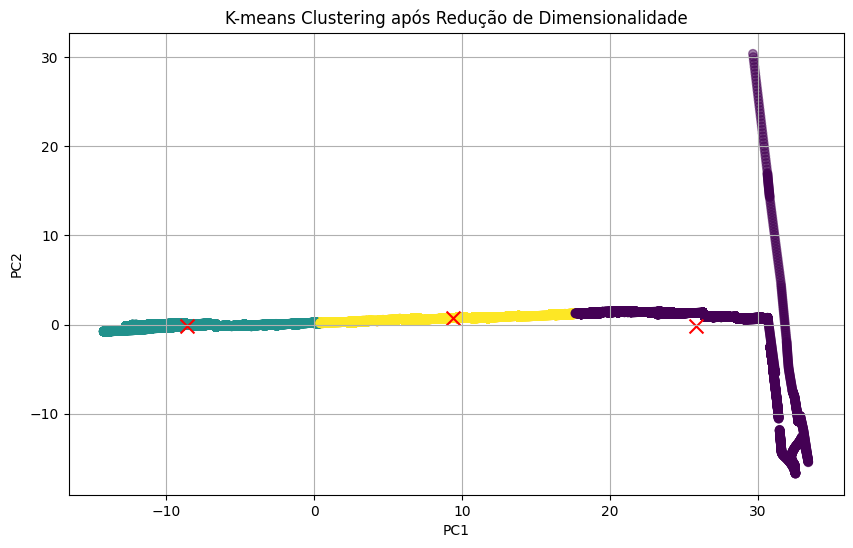

In [41]:
n_components = 4
pca = PCA(n_components=n_components)
scaler = StandardScaler()
X = scaler.fit_transform(df_preprocessing.drop(columns="class"))
X_pca = pca.fit_transform(X)
kmeans_six_variables(X_pca, n_clusters=3)

In [42]:
list_comp = [f"COMP_{x+1}"  for x in range(n_components)]
df_pca = pd.DataFrame(X_pca, columns=list_comp)
df_pca["class"] = df_preprocessing["class"].values

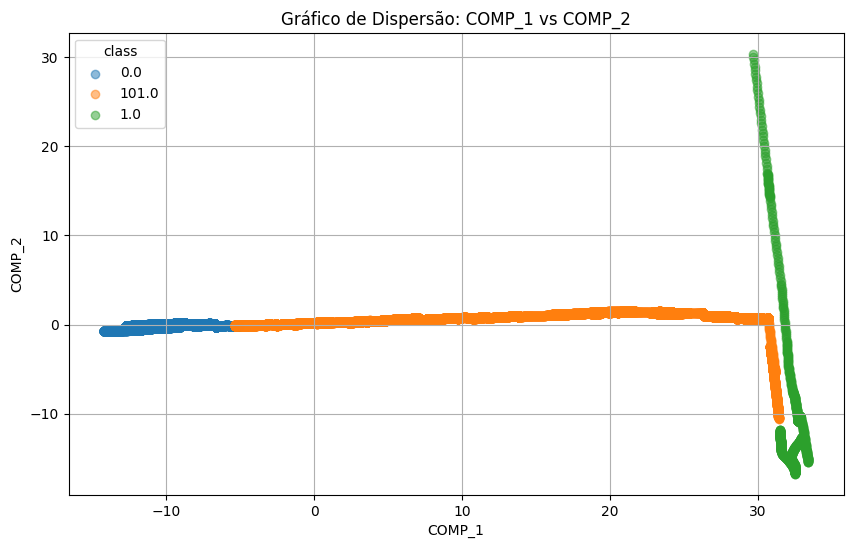

In [43]:
plot_two_variables(df_pca, 'COMP_1', 'COMP_2', binary_column="class")

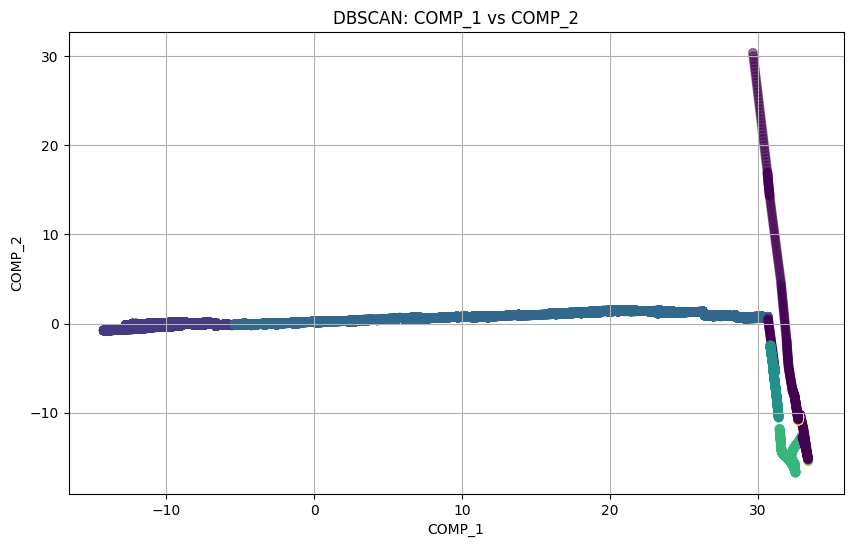

In [44]:
# Aplica o algoritmo DBSCAN
eps=0.05
min_samples=4
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
dbscan.fit(df_pca.drop(columns=["class"]))

# Plota os pontos
plt.figure(figsize=(10, 6))
plt.scatter(df_pca["COMP_1"], df_pca["COMP_2"], c=dbscan.labels_, cmap='viridis', alpha=0.5)
plt.xlabel("COMP_1")
plt.ylabel("COMP_2")
plt.title(f'DBSCAN: {"COMP_1"} vs {"COMP_2"}')
plt.grid(True)
plt.show()

In [45]:
silhouette_score(df_pca.drop(columns=["class"]), dbscan.labels_)

0.48112909272292054

In [46]:
davies_bouldin_score(df_pca.drop(columns=["class"]), dbscan.labels_)

1.0656532761115132

In [47]:
dbscan.labels_

array([ 0,  0,  0, ..., -1, -1, -1], dtype=int64)

# ConclusÃo

- Poly 2; Atraso T-TPT; 4 componentes -> 0.4811290927229205 ; 1.0656532761115183

- Poly 2; Sem atraso T-TPT; 4 componentes -> 0.7356473574951891 ; 1.2126837938408157

- Sem transformações (Só com PCA) -> 0.6745643331326939 ; 1.3674506962098432

In [ ]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

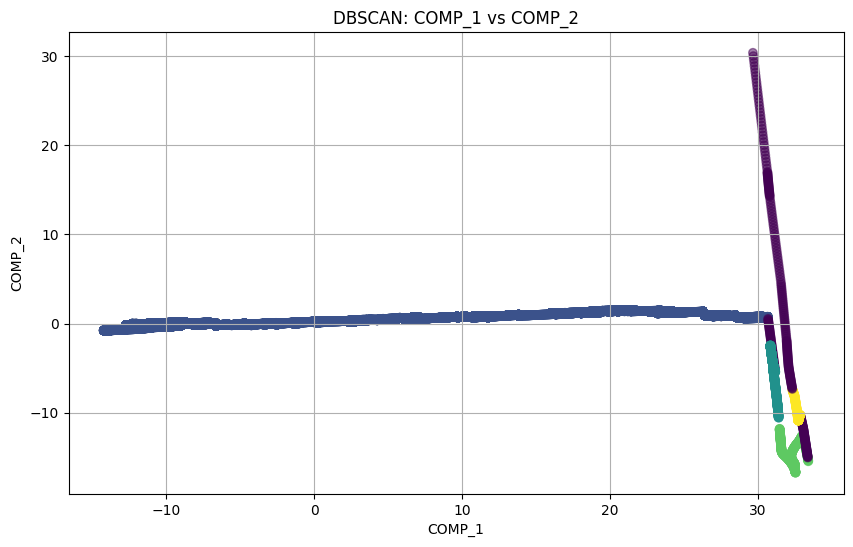

In [560]:
# Aplica o algoritmo DBSCAN
# Esse algoritmo conseguiu separar em duas classes muito bem!!!!!!
eps=0.1
min_samples=5
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
dbscan.fit(df_pca.drop(columns=["class"]))

# Plota os pontos
plt.figure(figsize=(10, 6))
plt.scatter(df_pca["COMP_1"], df_pca["COMP_2"], c=dbscan.labels_, cmap='viridis', alpha=0.5)
plt.xlabel("COMP_1")
plt.ylabel("COMP_2")
plt.title(f'DBSCAN: {"COMP_1"} vs {"COMP_2"}')
plt.grid(True)
plt.show()

In [561]:
def grid_search_dbscan(X, eps_values, min_samples_values):
    """
    Realiza uma busca em grade para encontrar os melhores valores de eps e min_samples para o DBSCAN.

    Parâmetros:
        - X: Matriz de features.
        - eps_values: Lista de valores para o parâmetro eps.
        - min_samples_values: Lista de valores para o parâmetro min_samples.

    Retorna:
        - Melhores valores de eps e min_samples.
    """
    best_eps = None
    best_min_samples = None
    best_score = -1

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
            labels = dbscan.fit_predict(X)
            unique_labels = np.unique(labels)
            if len(unique_labels) > 1:  # Verifica se há mais de um cluster
                score = silhouette_score(X, labels)
                if score > best_score:
                    best_score = score
                    best_eps = eps
                    best_min_samples = min_samples

    return best_eps, best_min_samples

# Exemplo de uso:
# Supondo que 'X' seja a sua matriz de features e 'eps_values' e 'min_samples_values' sejam as listas de valores para os parâmetros
best_eps, best_min_samples = grid_search_dbscan(df_pca.drop(columns=["class"]), eps_values=[0.01, 0.1, 0.5, 1.0], min_samples_values=[2, 5, 10])

In [562]:
best_min_samples

2

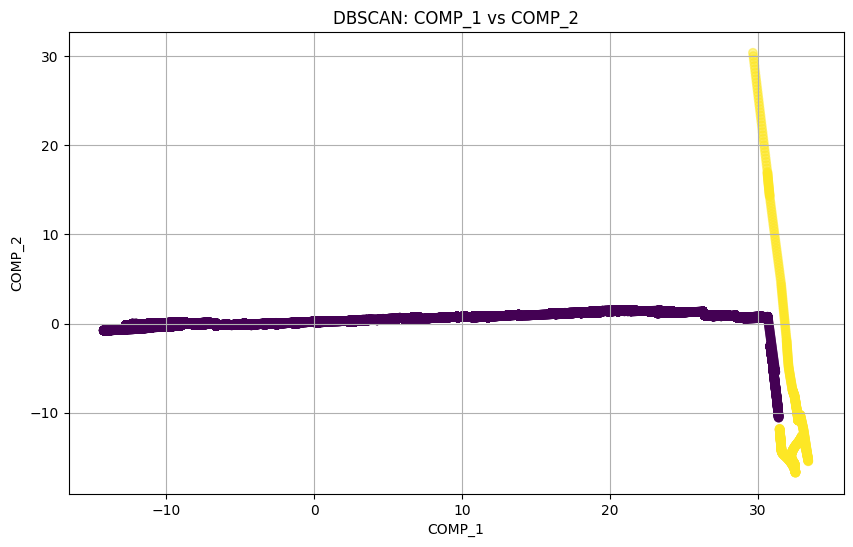

In [563]:
# Aplica o algoritmo DBSCAN
# Esse algoritmo conseguiu separar em duas classes muito bem!!!!!!
eps=best_eps
min_samples=best_min_samples
dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
dbscan.fit(df_pca.drop(columns=["class"]))

# Plota os pontos
plt.figure(figsize=(10, 6))
plt.scatter(df_pca["COMP_1"], df_pca["COMP_2"], c=dbscan.labels_, cmap='viridis', alpha=0.5)
plt.xlabel("COMP_1")
plt.ylabel("COMP_2")
plt.title(f'DBSCAN: {"COMP_1"} vs {"COMP_2"}')
plt.grid(True)
plt.show()

# Conclusão

Agrupamento por arquivo .csv funciona muito bem com o apoio do GridSearch com o método da silhueta.

Deverá ser testado:
- Com todos os dados da falha 1
- Com todos os dados por poço
    - Dados do poço 6: atrasar 180 e aumentar a PCA para 4, DBSCAN consegue identificar melhor.
        - Polynomial features do 3 grau ficou interessante -> Tem que ver se o gri search vai achar uma configuração melhor!!!!